In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import spatialmaps as sp
import septum_mec.analysis.data_processing as dp
import expipe
import os
import neo
import pathlib
import numpy as np
import elephant as el
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import optogenetics as og
import quantities as pq

In [2]:
par = {'speed_filter': 5, # m/s
    'pos_fs': 100 ,
    'f_cut': 6 ,
    'spat_binsize': 0.02 ,
    'grid_stepsize': 0.1 ,
    'box_xlen': 1 ,
    'box_ylen': 1 ,
    'spike_size': 10,
    'field_max_wall_extent':0.1,
    'field_min_bins':12
}

binsize = par['spat_binsize']
smoothing = 0.03
plt.rcParams['figure.figsize'] = (16,9)

In [3]:
project_path = os.environ.get("SEPTUM_MEC_DATA")
if project_path is None:
    raise Exception("Need to set `SEPTUM_MEC_DATA` as environment variable first.")
else:
    project_path = pathlib.Path(project_path)

project = expipe.get_project(project_path)
actions = project.actions

In [17]:
action_id = "1834-060319-2"
channel_id = 0

action  = actions[action_id]

data_path = pathlib.Path(project_path) / "actions" / action_id / "data" / "main.exdir"
root_group = exdir.File(
    data_path, plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])

x, y, t, speed = dp.load_tracking(data_path, par)

spike_trains = dp.load_spiketrains(data_path, channel_id, waveform=False)
epochs = dp.load_epochs(data_path)

In [18]:
def make_spike_lfp_coherence(chx, t_start, t_stop, f_start, f_stop):
    t_start = t_start * pq.s
    t_stop = t_stop * pq.s
    for u, unit in enumerate(chx.units):
    
        cluster_group = unit.annotations.get('cluster_group') or 'noise'
        if cluster_group.lower() == 'noise':
            continue
        if unit.name is None:
            unit.name = 'cluster_{}'.format(unit.annotations['cluster_id'])

        anas = chx.analogsignals
        sampling_rates = [ana.sampling_rate for ana in anas]
        if len(np.unique(sampling_rates)) > 1:
            raise ValueError('Found multiple sampling rates')
        sampling_rate = min(sampling_rates).magnitude

        ana_arr = np.array([ana.flatten() for ana in anas]).T
        times = np.arange(0, ana_arr.shape[0] / sampling_rate, 1 / sampling_rate) * pq.s
        mask = (times > t_start) & (times < t_stop)
        times = times[mask]
        ana_arr = ana_arr[mask,:]
        ana_arr = neo.AnalogSignal(
            signal=ana_arr * anas[0].units, sampling_rate=anas[0].sampling_rate, t_start=t_start)
        chs = [ana.annotations['electrode_idx'] for ana in anas]
        sptr = unit.spiketrains[0]
        sptr = neo.SpikeTrain(
                sptr.times[(sptr.times > t_start) & (sptr.times < times[-1])],
                t_start=t_start, t_stop=times[-1])

        sigs, freqs = el.sta.spike_field_coherence(ana_arr, sptr, **{'nperseg': 2048})
        fig, axs = plt.subplots(1, 3)
        for sig, ch in zip(sigs.T, chs):
            axs[0].plot(freqs, sig, label='ch {}'.format(ch))
        axs[0].legend()
        axs[0].set_xlim(f_start, f_stop)
        axs[0].set_title('coherence')

        for ana, ch in zip(ana_arr.T, chs):
            axs[1].psd(ana, Fs=sampling_rate, NFFT=2048)
        axs[1].set_xlim(f_start, f_stop)
        axs[1].set_title('lfp psd')

        bins = np.arange(
            sptr.t_start.magnitude, sptr.t_stop.magnitude, 1 / sampling_rate) #time bins for spikes
        #firing rate histogram
        hist = np.histogram(sptr, bins=bins)[0].astype(float)
        hist -= hist.mean()
        axs[2].psd(hist, Fs=sampling_rate, NFFT=2048)
        axs[2].set_xlim(f_start, f_stop)
        axs[2].set_title('spike psd')


In [19]:
io = neo.ExdirIO(str(data_path), plugins=[exdir.plugins.quantities, exdir.plugins.git_lfs])
blk = io.read_block(channel_group_idx=0)
seg = blk.segments[0]
chxs = blk.channel_indexes

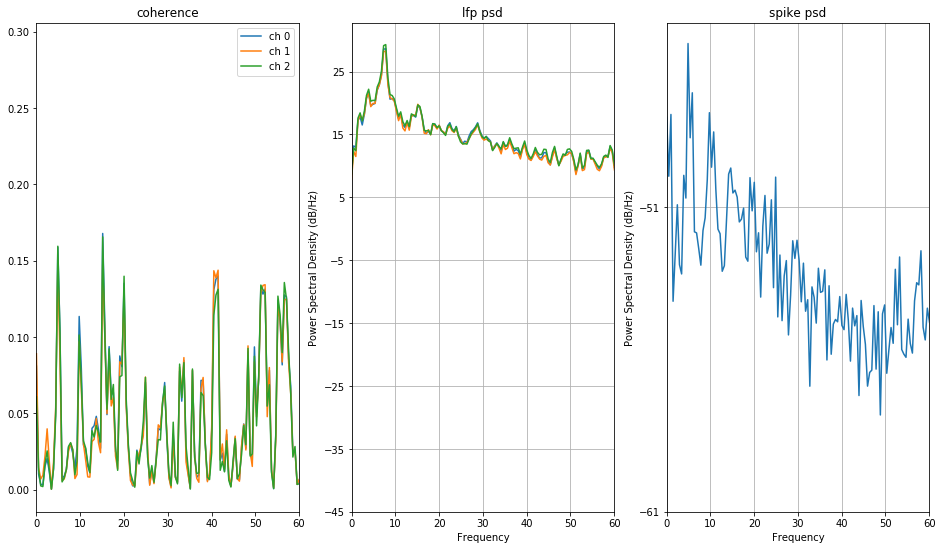

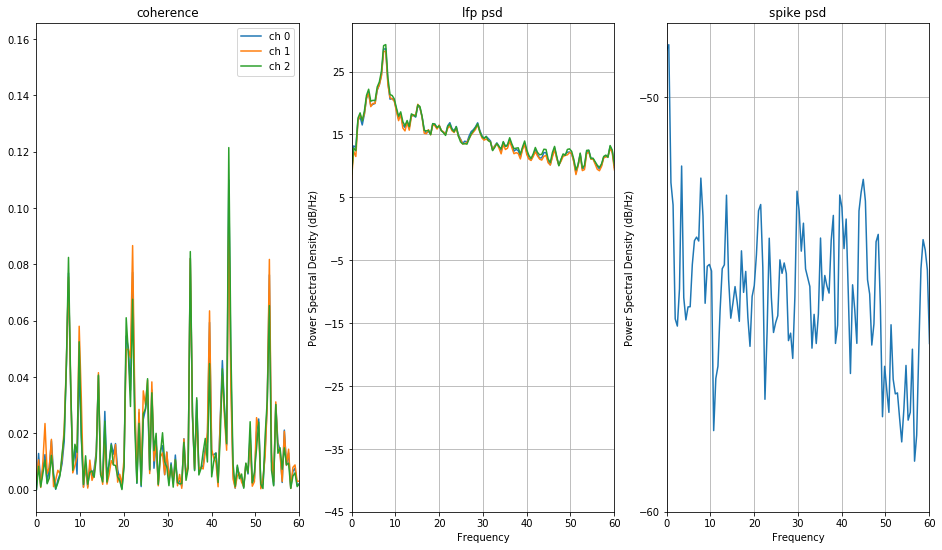

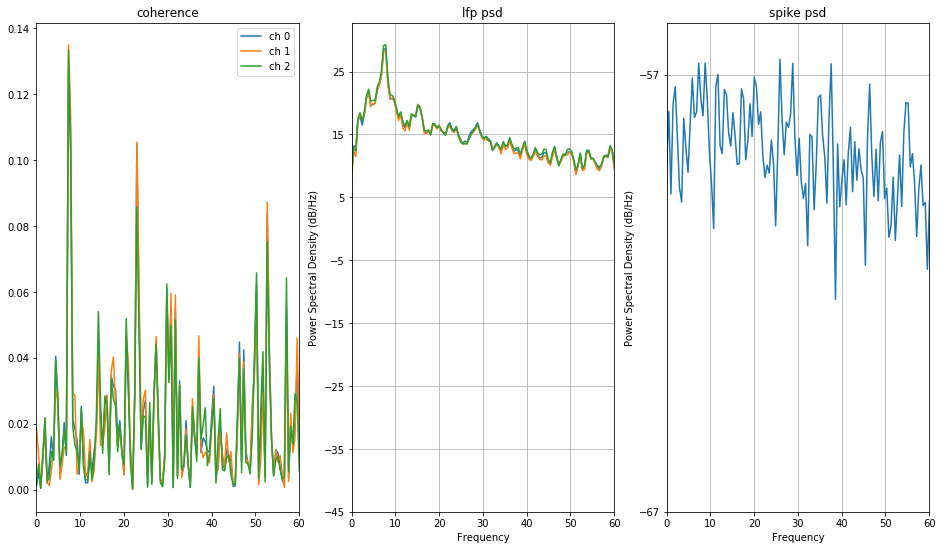

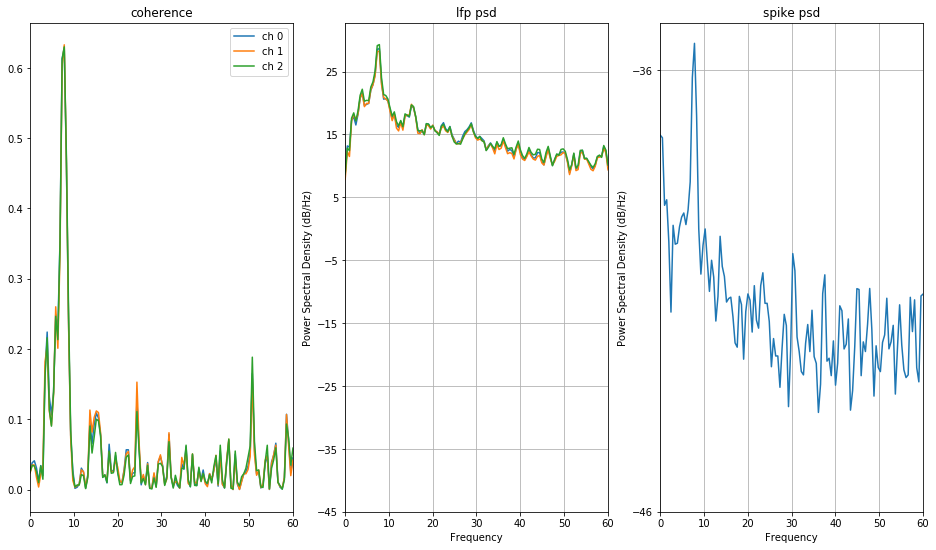

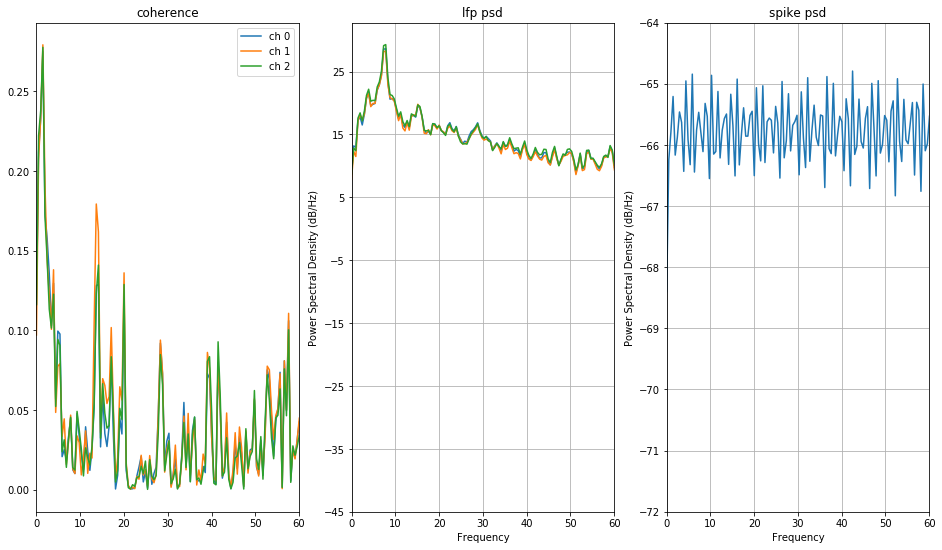

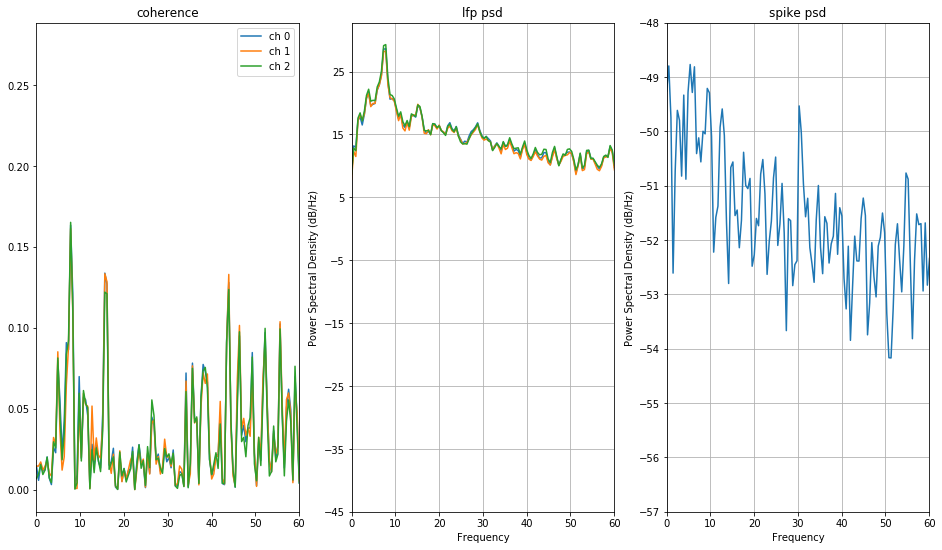

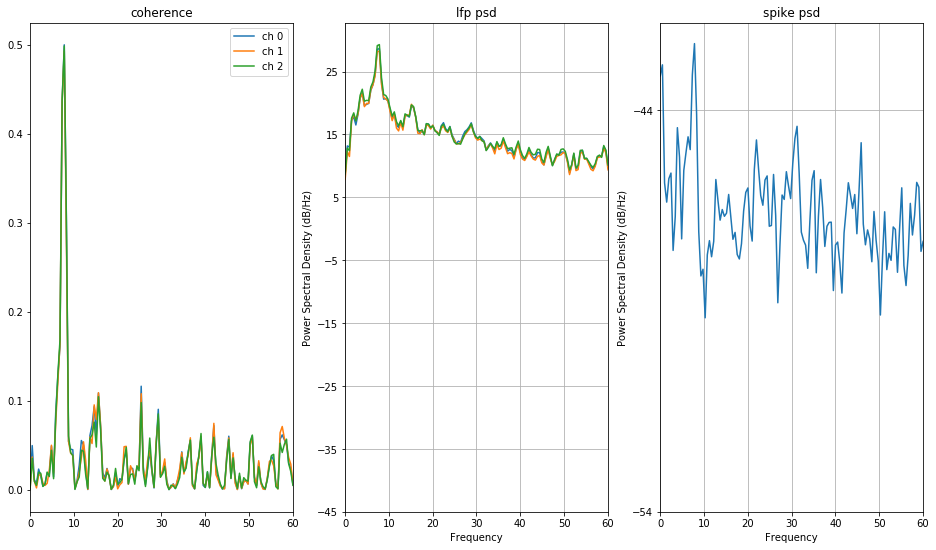

In [20]:
make_spike_lfp_coherence(chxs[0], 0, 60, 0, 60)

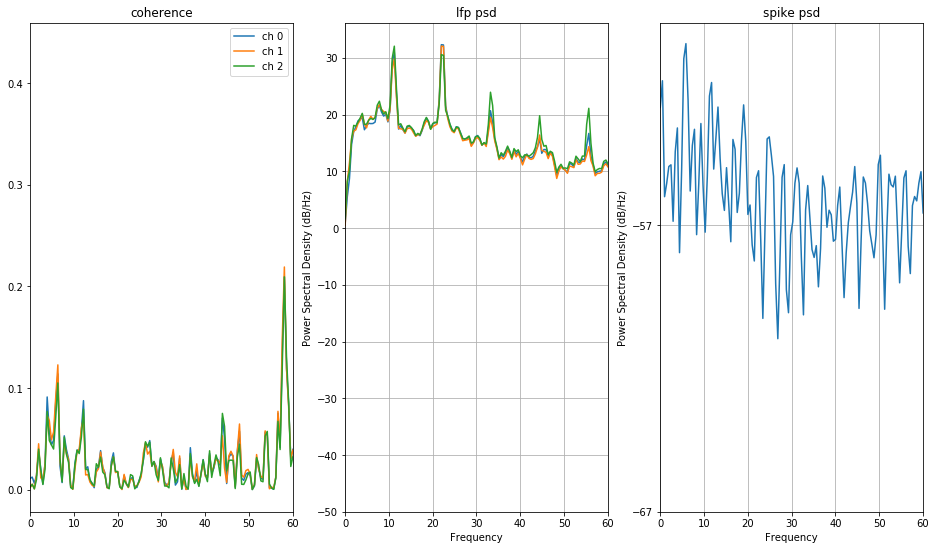

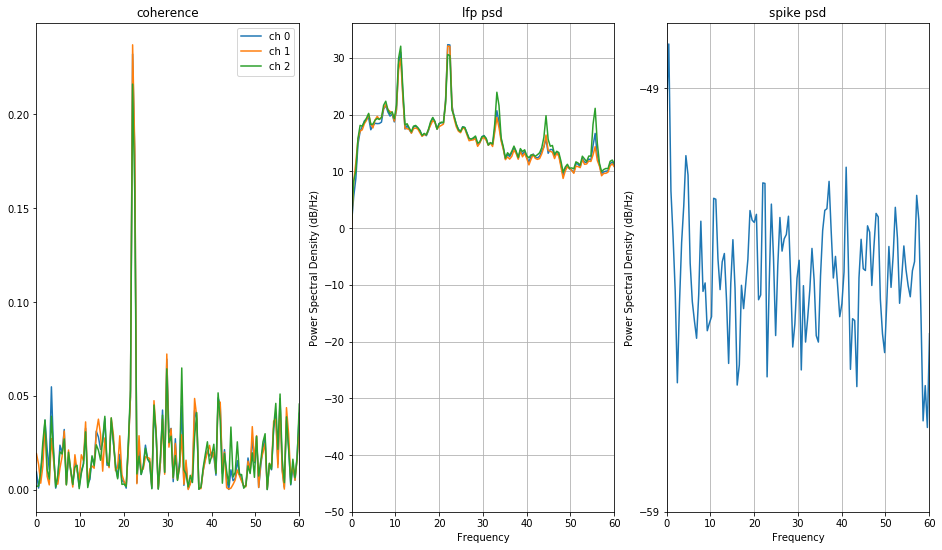

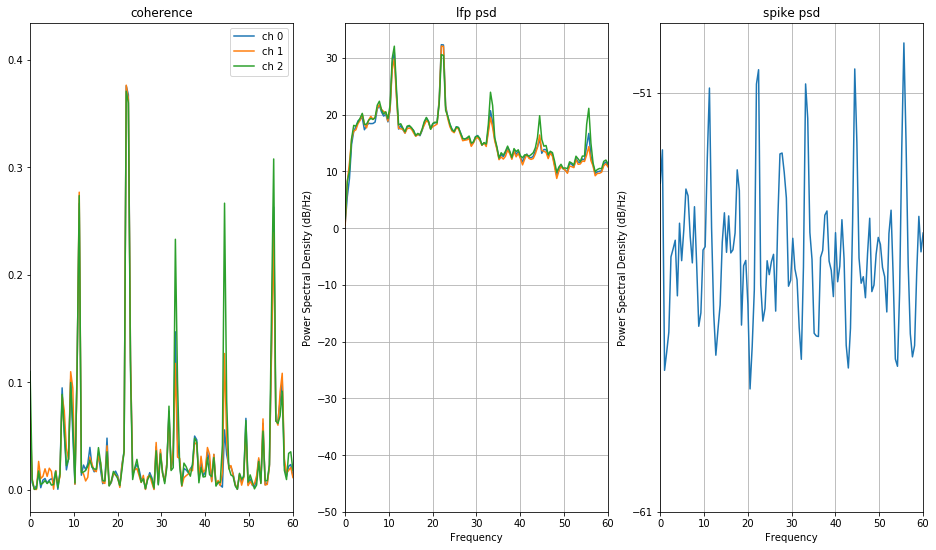

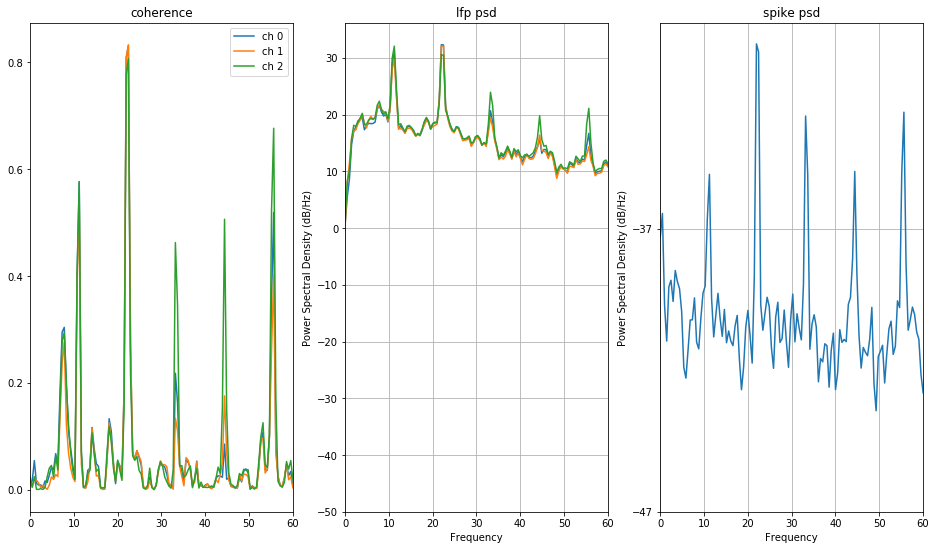

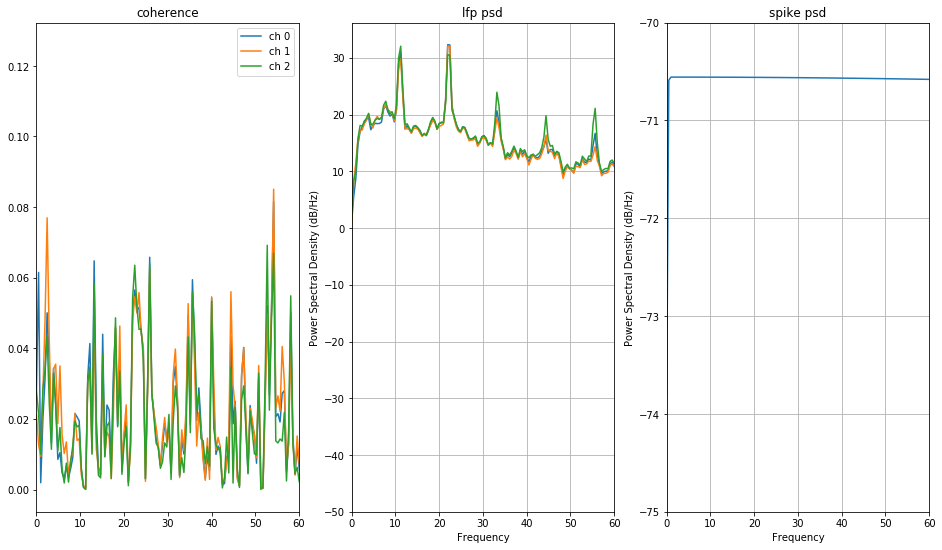

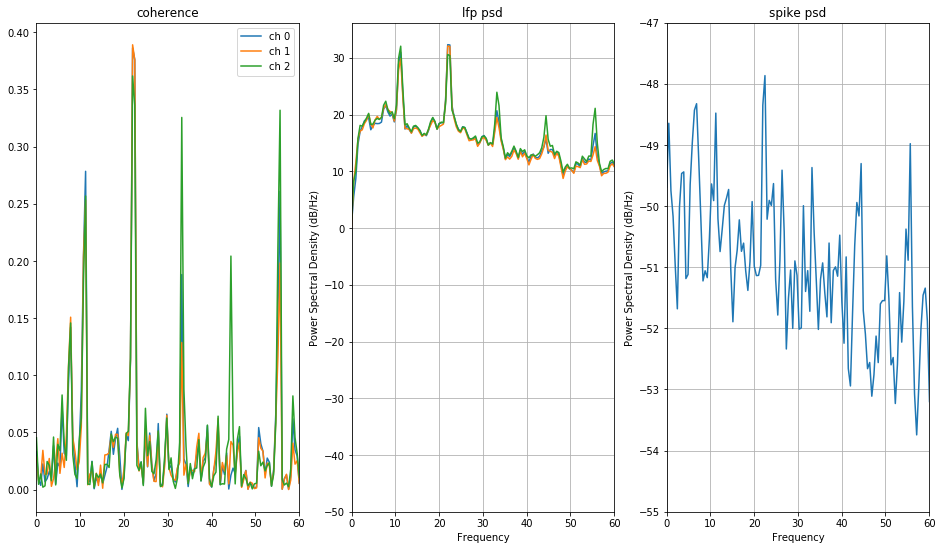

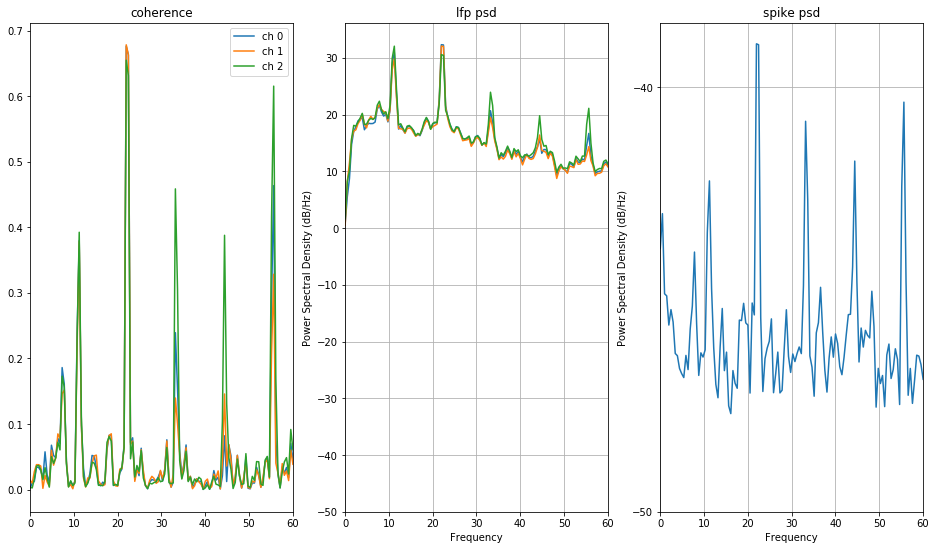

In [21]:
make_spike_lfp_coherence(chxs[0], 100, 160, 0, 60)